<a href="https://colab.research.google.com/github/caiocfpeixoto/PDI/blob/cv_functions/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import  cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
def find_red_objects(image):
    # Convertendo a imagem para o espaço de cores HSV
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Definindo os limites inferior e superior para detecção de vermelho
    lower_red = np.array([0, 50, 50])  # Matiz mínimo, saturação mínima e valor mínimo
    upper_red = np.array([10, 255, 255])  # Matiz máximo, saturação máxima e valor máximo

    # Criando uma máscara para pixels na faixa de cores vermelhas
    mask = cv.inRange(hsv_image, lower_red, upper_red)

    # Aplicando a máscara à imagem original
    red_objects = cv.bitwise_and(image, image, mask=mask)

    # Aplicando a função bwareaopen para remover objetos pequenos
    gray_image = cv.cvtColor(red_objects, cv.COLOR_BGR2GRAY)
    _, threshold = cv.threshold(gray_image, 1, 255, cv.THRESH_BINARY)
    filtered_objects = cv.bitwise_and(red_objects, red_objects, mask=threshold)

    return filtered_objects

In [3]:
def detect_edges(image):
    # Convertendo a imagem para tons de cinza
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Aplicando o filtro de Sobel para detecção de bordas
    sobel_x = cv.Sobel(gray_image, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray_image, cv.CV_64F, 0, 1, ksize=3)

    # Calculando a magnitude dos gradientes
    gradient_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

    # Normalizando a magnitude dos gradientes para o intervalo [0, 255]
    gradient_magnitude_normalized = cv.normalize(gradient_magnitude, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

    # Aplicando uma limiarização para binarizar a imagem das bordas
    _, edges = cv.threshold(gradient_magnitude_normalized, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return edges

In [4]:
def dilate_edges(edges):
    # Definindo o kernel para a dilatação
    kernel = np.ones((3, 3), np.uint8)

    # Realizando a dilatação nas bordas
    dilated_edges = cv.dilate(edges, kernel, iterations=1)

    return dilated_edges

In [5]:
def fill_objects(edges):
    # Copiando a imagem das bordas para preservar a original
    filled_image = edges.copy()

    # Encontrando os contornos dos objetos nas bordas
    contours, _ = cv.findContours(filled_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Preenchendo os objetos conectados
    for contour in contours:
        cv.drawContours(filled_image, [contour], 0, (255), -1)

    return filled_image

In [6]:
def remove_border_objects(image):
    # Encontrando os contornos dos objetos na imagem
    contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Encontrando as dimensões da imagem
    height, width = image.shape[:2]

    # Definindo uma região de interesse (ROI) com base nas bordas
    roi = np.zeros_like(image)
    cv.rectangle(roi, (0, 0), (width - 1, height - 1), 255, -1)

    # Verificando quais objetos estão em contato com a ROI
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if cv.pointPolygonTest(contour, (x, y), False) == 1.0:
            cv.drawContours(image, [contour], 0, 0, -1)

    return image

In [7]:
def improve_object_definition(image):
    # Definindo o kernel para a erosão
    kernel = np.ones((3, 3), np.uint8)

    # Realizando a erosão na imagem
    eroded_image = cv.erode(image, kernel, iterations=1)

    return eroded_image

In [28]:
# Carregando a imagem
img_filename = "1.jpg"
img = cv.imread(cv.samples.findFile("Pasta_img_original" + img_filename))

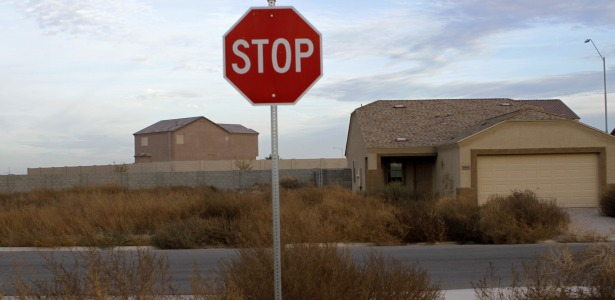

In [9]:
cv2_imshow(img)

In [10]:
# Resize in case of a image being too big.
imgRGB = cv.resize(img, (940, 540))

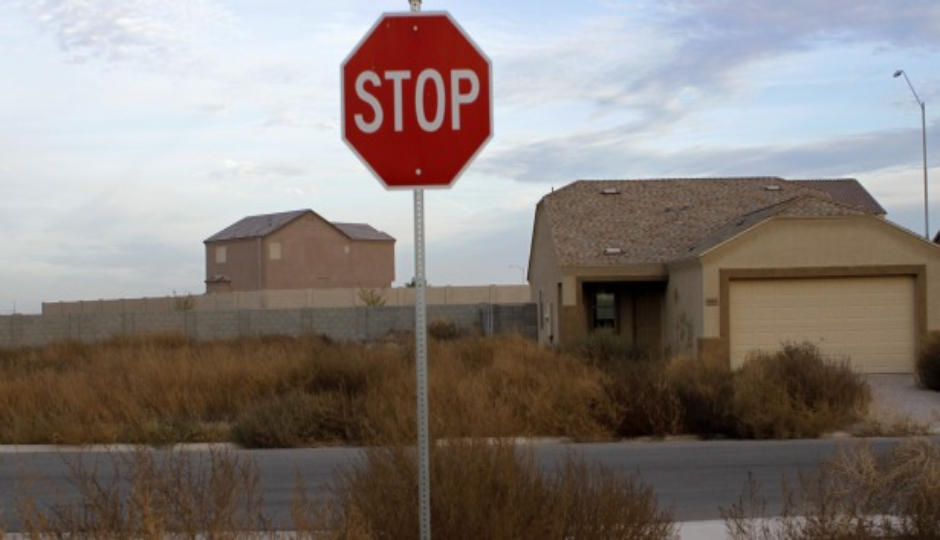

In [11]:
cv2_imshow(imgRGB)

In [12]:
# Alplicando borramento Gaussiano para eliminar ruídos
img_borrada= cv.GaussianBlur(imgRGB,(5,5),0)

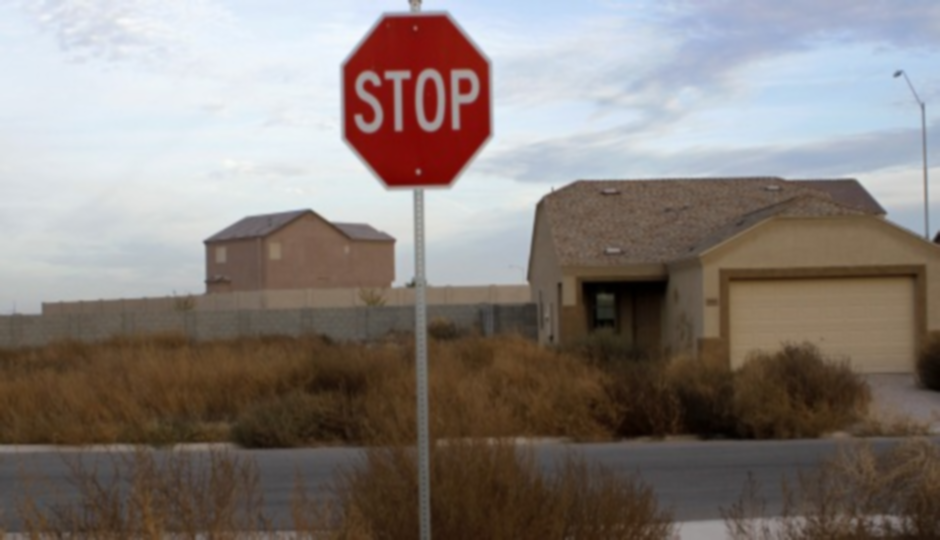

In [13]:
cv2_imshow(img_borrada)

In [14]:
# Chamando a função para encontrar os objetos vermelhos
red_objects = find_red_objects(img_borrada)

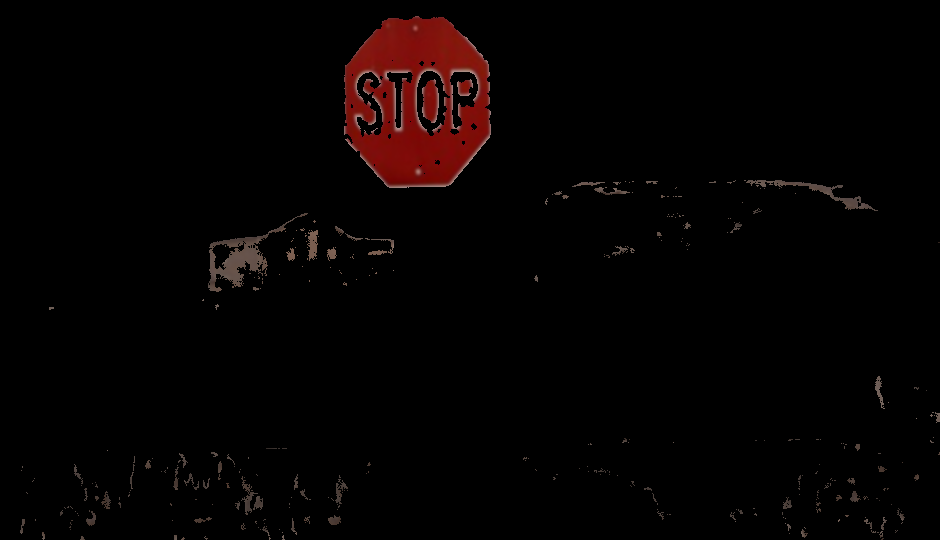

In [15]:
cv2_imshow(red_objects)

In [16]:
# Chamando a função para detectar as bordas na imagem segmentada
edges = detect_edges(red_objects)

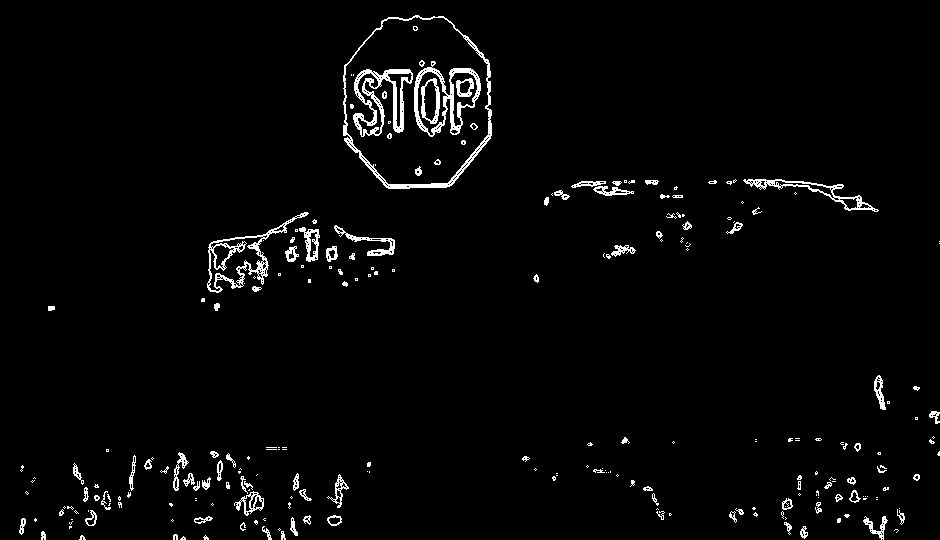

In [17]:
cv2_imshow(edges)

In [18]:
# Chamando a função para realizar a dilatação nas bordas
dilated_edges = dilate_edges(edges)

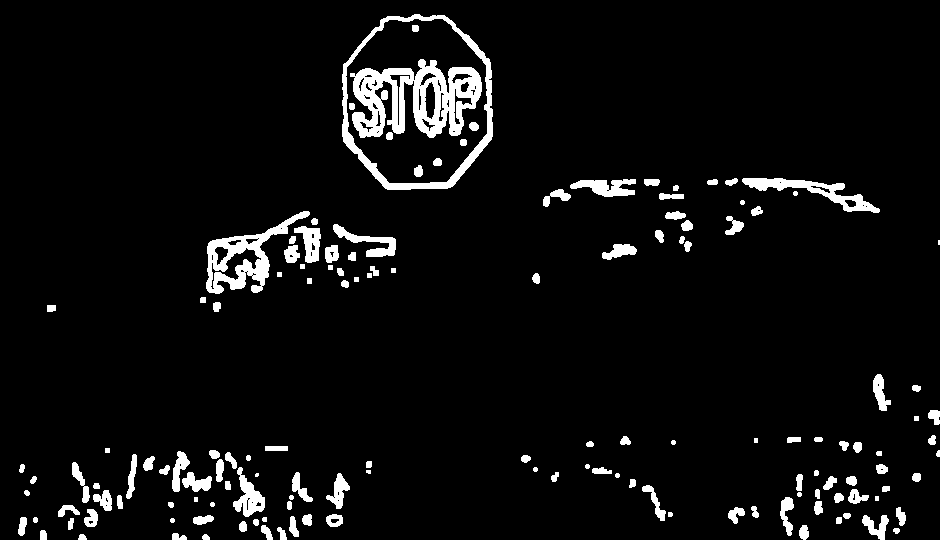

In [19]:
cv2_imshow(dilated_edges)

In [20]:
# Chamando a função para preencher o interior dos objetos conectados
filled_image = fill_objects(dilated_edges)

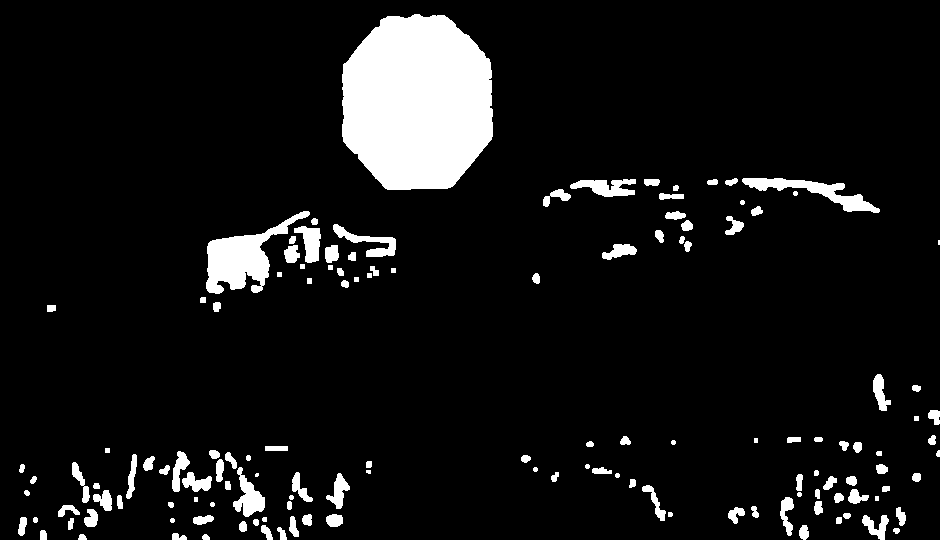

In [21]:
cv2_imshow(filled_image)

In [22]:
# Chamando a função para remover objetos conectados em contato com as bordas
processed_image = remove_border_objects(filled_image)

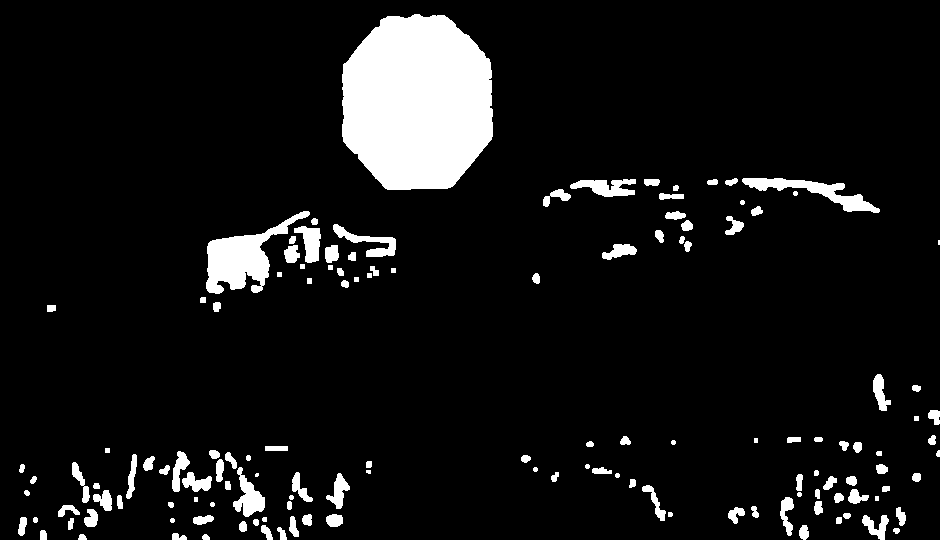

In [23]:
cv2_imshow(processed_image)

In [24]:
# Chamando a função para melhorar a definição do objeto detectado
improved_image = improve_object_definition(processed_image)

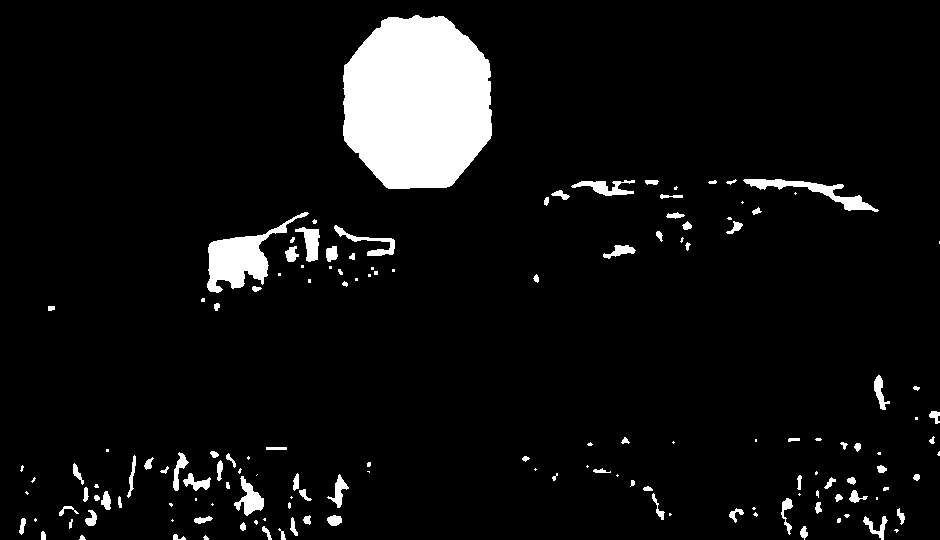

In [25]:
cv2_imshow(improved_image)

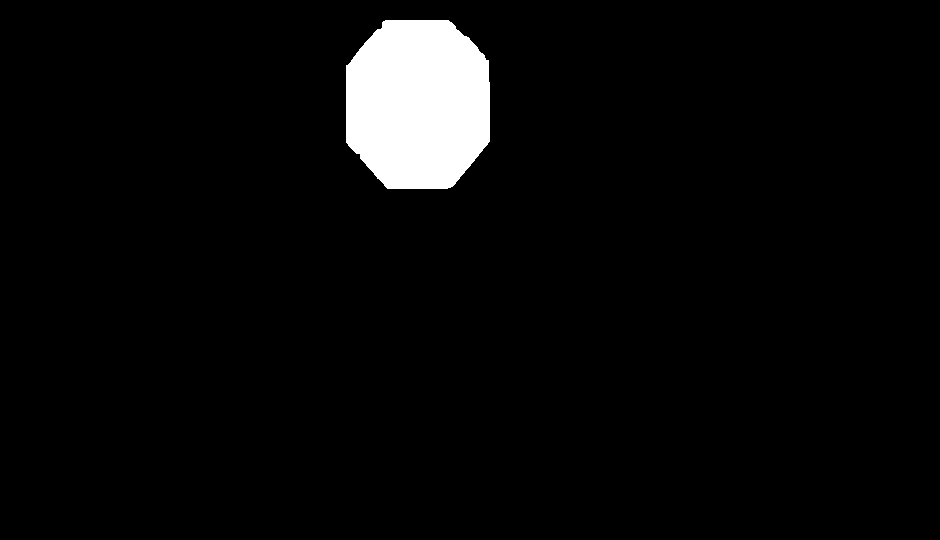

In [26]:
# Definir o kernel para a operação de abertura
kernel = np.ones((40, 40), np.uint8)

# Aplicar a operação de abertura
imagem_processada = cv.morphologyEx(improved_image, cv.MORPH_OPEN, kernel)

# Exibir a imagem resultante
cv2_imshow(imagem_processada)

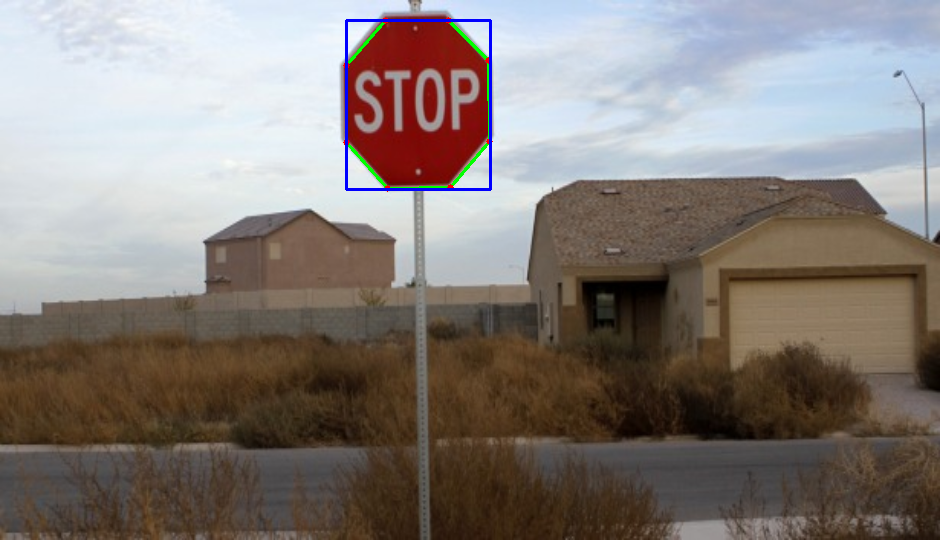

In [27]:
# Encontrar os contornos na imagem segmentada
contornos, _ = cv.findContours(imagem_processada, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Percorrer cada contorno
for contorno in contornos:
    # Aproximar o contorno por um polígono
    epsilon = 0.03 * cv.arcLength(contorno, True)
    poligono = cv.approxPolyDP(contorno, epsilon, True)
    
    # Verificar se o popolígono tem 6 vértices (hexágono)
    if len(poligono) >= 4 and len(poligono) <= 8:
        # Desenhar o contorno com retas e os vértices
        cv.polylines(imgRGB, [poligono], True, (0, 255, 0), 2)  # Desenha as retas do contorno
        for ponto in poligono:
            x, y = ponto[0]
            cv.circle(imgRGB, (x, y), 3, (0, 0, 255), -1)  # Marca os pontos dos vértices com círculos vermelhos
        
        # Obter as coordenadas do retângulo delimitador do contorno
        x, y, largura, altura = cv.boundingRect(contorno)
        
        # Desenhar o retângulo delimitador
        cv.rectangle(imgRGB, (x, y), (x + largura, y + altura), (255, 0, 0), 2)  # Desenha o retângulo delimitador em azul

# Exibir a imagem com o contorno, os vértices e o retângulo
cv2_imshow(imgRGB)

In [30]:
cv.imwrite("Pasta_img_samples" + img_filename, imgRGB)

True